# IMPORT MODULES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
from sklearn.pipeline import Pipeline

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

bc = pd.read_csv('seatle_after_feature_engineering.csv')

# SiteEnergyUse

/Users/tico/Library/Python/3.9/lib/python/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


DummyRegressor R² : -0.0020413757530890475
DummyRegressor MAE : 1701739.4651428866
DummyRegressor MAPE : 129.24195950409282
DummyRegressor RMSE : 4976891129433.967
#######################################
LinearRegression R²: 0.5209885130546641
LinearRegression MAE : 1117113.9102794959
LinearRegression MAPE: 71.46658067517873
LinearRegression RMSE: 2379131319286.61
#######################################


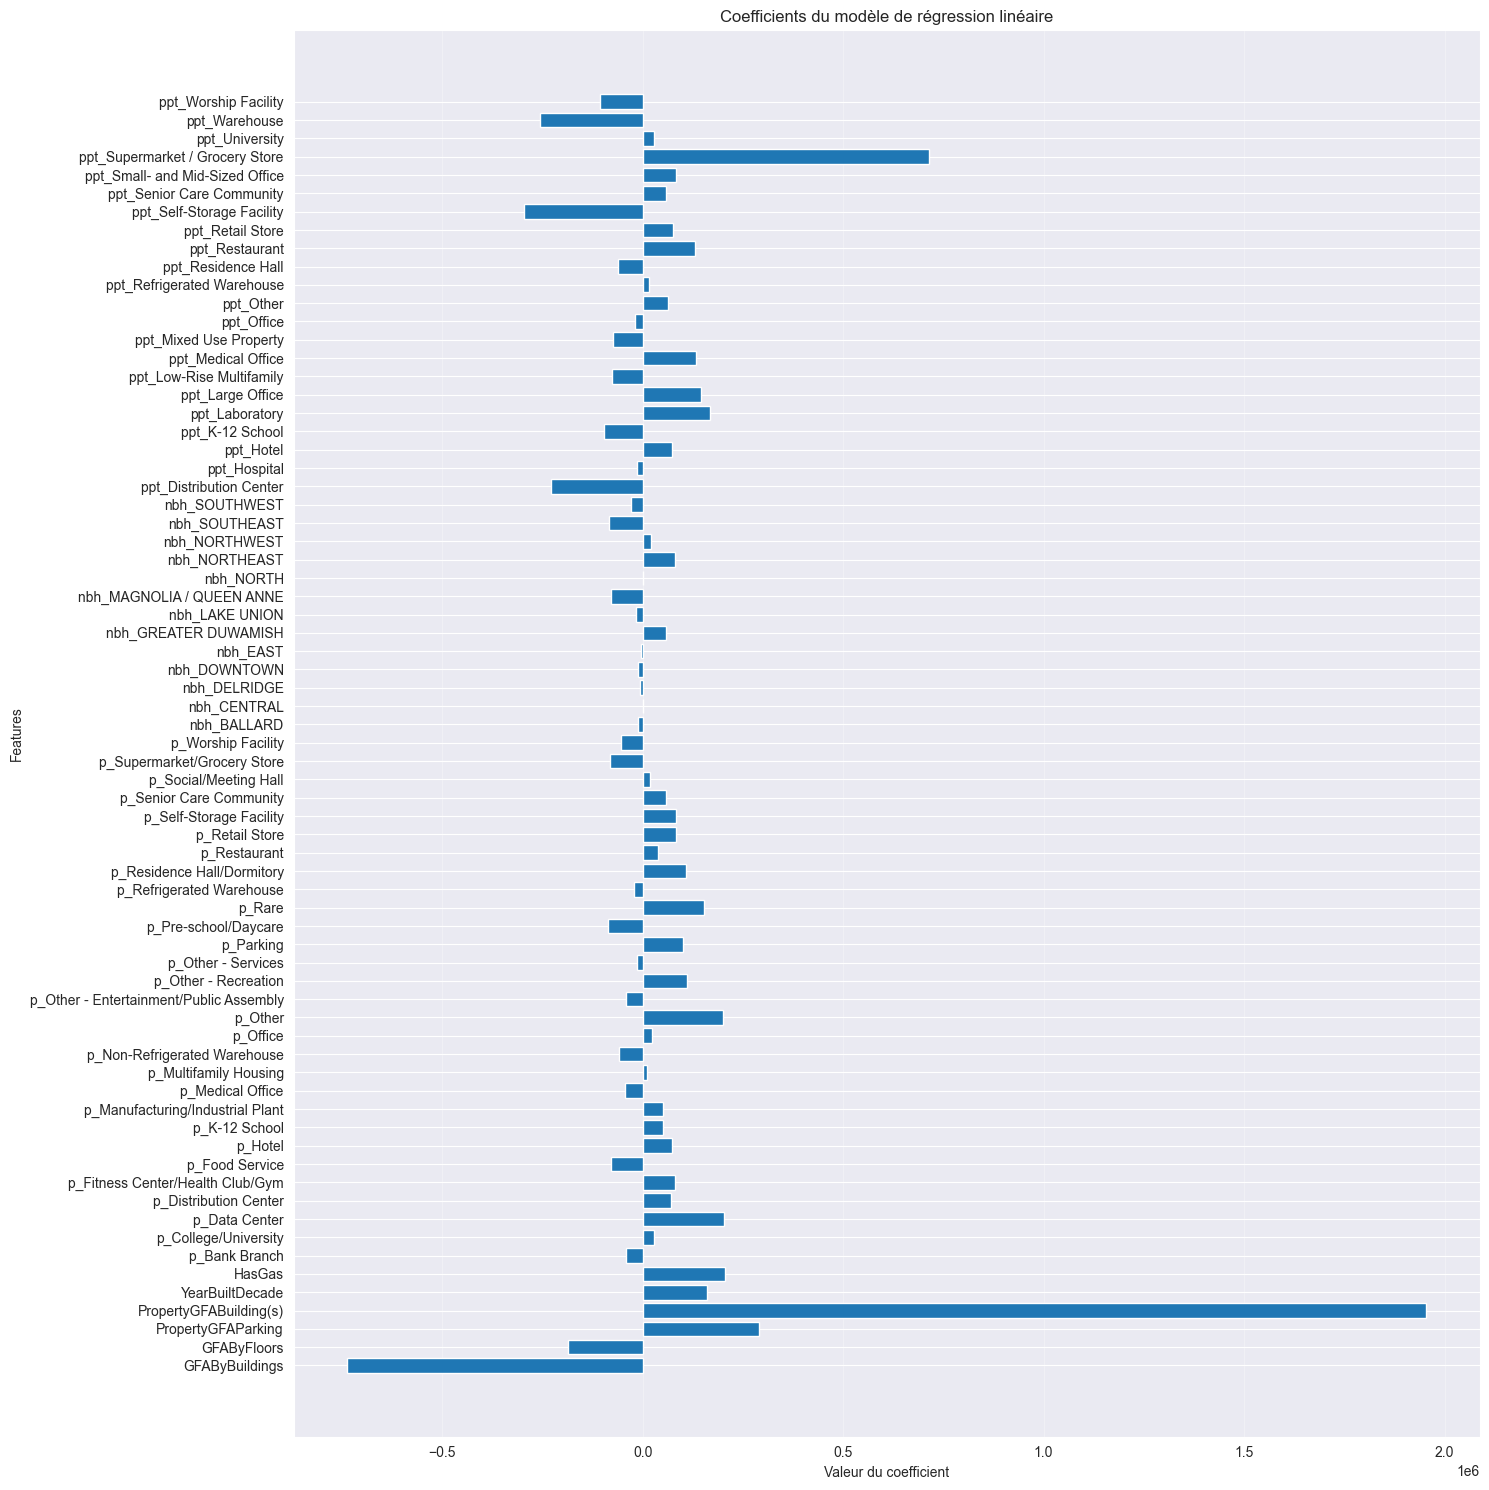

SVR R² : -0.14186314045152093
SVR MAE : 1609758.4989063484
SVR MAPE : 90.01615074147627
SVR RMSE : 5671351175962.923
#######################################
                                    feature  importance
3                    PropertyGFABuilding(s)    0.392533
66          ppt_Supermarket / Grocery Store    0.085719
0                            GFAByBuildings    0.077920
1                               GFAByFloors    0.067558
2                        PropertyGFAParking    0.058912
..                                      ...         ...
20  p_Other - Entertainment/Public Assembly    0.000242
54                 ppt_Low-Rise Multifamily    0.000168
24                     p_Pre-school/Daycare    0.000123
49                             ppt_Hospital    0.000042
57                               ppt_Office    0.000011

[70 rows x 2 columns]


In [2]:
# Calcul de la surface par batiment
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofBuildings']
bc['GFAByBuildings'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

# Calcul de la surface par etages
a = bc['PropertyGFABuilding(s)']
b = bc['NumberofFloors']
bc['GFAByFloors'] = np.divide(a, b, out=np.zeros_like(a), where=b!=0)

base_columns = ['GFAByBuildings', 'GFAByFloors', 'PropertyGFAParking','PropertyGFABuilding(s)','YearBuiltDecade', 'HasGas']
p_columns = [col for col in bc.columns if col.startswith('p_')]
ppt_columns = [col for col in bc.columns if col.startswith('ppt_')]
nbh_columns = [col for col in bc.columns if col.startswith('nbh_')]
all_columns = base_columns + p_columns  + nbh_columns  + ppt_columns

X = bc[all_columns]
y = bc['SiteEnergyUse(kBtu)']

#######################################
#######################################
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)
# Baseline Dummy Regressor
dummy = DummyRegressor(strategy="mean")  # ou "median"
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

# Évaluation
print("DummyRegressor R² :", r2_score(y_test, y_pred))
print("DummyRegressor MAE :", mean_absolute_error(y_test, y_pred))
print("DummyRegressor MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("DummyRegressor RMSE :", mean_squared_error(y_test, y_pred))
print("#######################################")

#######################################
#######################################

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

model = LinearRegression()
model.fit(X_train_scaler, y_train)

y_pred = model.predict(X_test_scaler)

#print(f"LinearRegression Coeff: {model.coef_}")

print(f"LinearRegression R²: {r2_score(y_test, y_pred)}")
print("LinearRegression MAE :", mean_absolute_error(y_test, y_pred))
print(f"LinearRegression MAPE: {mean_absolute_percentage_error(y_test, y_pred)*100}")
print(f"LinearRegression RMSE: {mean_squared_error(y_test, y_pred)}")
print("#######################################")

plt.figure(figsize=(15, 15))  # Plus large pour accommoder plus de features

plt.barh(list(X.columns), model.coef_)
plt.title('Coefficients du modèle de régression linéaire')
plt.xlabel('Valeur du coefficient')
plt.ylabel('Features')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

#######################################
#######################################

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)

# Pipeline avec scaling (indispensable pour SVR)
svr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale"))
])

# Entraînement
svr.fit(X_train, y_train)

# Prédiction
y_pred = svr.predict(X_test)

# Évaluation
print("SVR R² :", r2_score(y_test, y_pred))
print("SVR MAE :", mean_absolute_error(y_test, y_pred))
print("SVR MAPE :", mean_absolute_percentage_error(y_test, y_pred)*100)
print("SVR RMSE :", mean_squared_error(y_test, y_pred))
print("#######################################")


#######################################
#######################################

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=666)

# Entraînement
rf = RandomForestRegressor(n_estimators=200, random_state=666)
rf.fit(X_train, y_train)

# Importances
importances = rf.feature_importances_

# Associer noms de colonnes + importance
feat_importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(feat_importances)



# Cross_val_score

In [3]:
from sklearn.model_selection import KFold


def perform_cross_validation(
    X: pd.DataFrame,
    y: pd.Series,
    model,
    cross_val_type, # La variante de validation croisée que nous souhaitons utiliser
    scoring_metrics: tuple, # Metriques de notre choix
    return_estimator=False, # Si nous souhaitons stocker les modèles de chaque fold
    groups=None, # Nous verrons l’utilité de cet argument juste après
):
    scores = cross_validate(
        model,
        X.to_numpy(),
        y.to_numpy(),
        cv=cross_val_type,
        return_train_score=True,
        return_estimator=return_estimator,
        scoring=scoring_metrics,
        groups=groups,
    )

    for metric in scoring_metrics:
        print(
            "Average Train {metric} : {metric_value}".format(
                metric=metric,
                metric_value=np.mean(scores["train_" + metric]),
            )
        )
        print(
            "Train {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["train_" + metric])
            )
        )

        print(
            "Average Test {metric} : {metric_value}".format(
                metric=metric, metric_value=np.mean(scores["test_" + metric])
            )
        )
        print(
            "Test {metric} Standard Deviation : {metric_value}".format(
                metric=metric, metric_value=np.std(scores["test_" + metric])
            )
        )

    return scores


linear_model = LinearRegression()
classification_scoring_metrics = ("neg_mean_squared_error", "r2", "neg_mean_absolute_error")

scores_LinearRegression = perform_cross_validation(
    X=X,
    y=y,
    model=linear_model,
    cross_val_type=KFold(n_splits=5, shuffle=True, random_state=666), #Par défaut, le nombre de folds est 5
    scoring_metrics=classification_scoring_metrics,
)




Average Train neg_mean_squared_error : -1790669352378.8345
Train neg_mean_squared_error Standard Deviation : 62867382253.69365
Average Test neg_mean_squared_error : -2112768513621.976
Test neg_mean_squared_error Standard Deviation : 235150562771.29483
Average Train r2 : 0.6312537964901658
Train r2 Standard Deviation : 0.009642529627767835
Average Test r2 : 0.5640456204052675
Test r2 Standard Deviation : 0.03283712297562252
Average Train neg_mean_absolute_error : -973056.7024850158
Train neg_mean_absolute_error Standard Deviation : 21412.491433591567
Average Test neg_mean_absolute_error : -1053140.714406569
Test neg_mean_absolute_error Standard Deviation : 52545.04149598929


/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/tico/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: i

# RandomForestRegressor